In [1]:
import torch
import torch.nn.functional as F
import got_utils
import numpy as np
import pandas as pd
import os
import json
import time

from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset example
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y


class CodingData:
    def __init__(self, ROOT):
        try:
            self.act = torch.from_numpy(np.load(os.path.join(ROOT, 'acts.npy'))) # (Samples, Layers, Dim)
        except:
            self.act = None
        # with open(os.path.join(ROOT, 'labeled_data.json')) as f:
        #     self.data = json.load(f)
        self.data = pd.read_json(os.path.join(ROOT, 'labeled.json'))
        self.label_tensor = torch.zeros(len(self.data))
        for i in range(len(self.data)):
            self.label_tensor[i] = int(self.data['label'][i])
        self.pcs = []
        if self.act is not None:
            for i in range(self.act.shape[1]):
                self.pcs.append(got_utils.get_pcs(self.act.T[:, i, :]))

    def get_dataloader(self, layer, batch_size=32):
        dataset = MyDataset(self.act[:, layer, :], self.label_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    def plot_pcs(self, layer):
        if self.act is None:
            print('No activations found')
            return
        scatter = plt.scatter(self.pcs[layer].numpy()[:,0], self.pcs[layer].numpy()[:,1], c=self.data['label'], cmap='tab20')
        # Create legend entries for True and False
        handles, _ = scatter.legend_elements()
        labels = ['False', 'True']
        
        # Add the legend with custom labels
        plt.legend(handles, labels)
        plt.show()

    @property
    def hallucination_rate(self):
        return 1 - self.label_tensor.mean()
    

def compare_sets(base, chat):
    print(f"Base: {base.hallucination_rate}")
    print(f"Chat: {chat.hallucination_rate}")
    improve_indices = np.where(
        (base.label_tensor == 0) & (chat.label_tensor == 1)
    )[0]
    degrade_indices = np.where(
        (base.label_tensor == 1) & (chat.label_tensor == 0)
    )[0]
    both_halluc_indices = np.where(
        (base.label_tensor == 0) & (chat.label_tensor == 0)
    )[0]
    both_real_indices = np.where(
        (base.label_tensor == 1) & (chat.label_tensor == 1)
    )[0]

    print(f"{len(improve_indices)} hallucinations improved ({len(improve_indices) / len(base.data) * 100:.2f}%)")   
    print(f"{len(degrade_indices)} hallucinations degraded ({len(degrade_indices) / len(base.data) * 100:.2f}%)")

    return {'improve_indices':improve_indices, 'degrade_indices':degrade_indices, 'both_halluc_indices':both_halluc_indices, 'both_real_indices':both_real_indices}

def view_sets(base, chat, indices):
    for i in indices:
        print(base.data.iloc[i]['explanation'], base.data.iloc[i]['label'])
        print(chat.data.iloc[i]['explanation'], chat.data.iloc[i]['label'])
        print('\n\n')
    


## Visualization

In [105]:
def plot_summary_pcs(data):
# put 10, 20, 30 in a subplot together
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    interval = len(data.pcs) // 3 - 1
    for i, ax in enumerate(axs):
        scatter = ax.scatter(data.pcs[interval*(i+1)].numpy()[:,0], data.pcs[interval*(i+1)].numpy()[:,1], c=data.data['label'], cmap='tab20')
        ax.set_title(f'Layer {10*(i+1)}')
        handles, _ = scatter.legend_elements()
        labels = ['False', 'True']
        ax.legend(handles, labels)
    plt.show()

## Linear Probes

In [14]:
from probes import LinearProbe

In [110]:
probe = LinearProbe(data.act.shape[2], 2)

In [15]:
def train(probe, data, layer, epochs=1, lr=1e-3, device='cpu', batch_size=32):
    optimizer = torch.optim.Adam(probe.parameters(), lr=lr)
    losses = []
    accuracies = []
    for epoch in range(epochs):
        for x, y in tqdm(data.get_dataloader(layer, batch_size=32)):
            x = x.to(device)
            optimizer.zero_grad()
            y_hat = probe(x)
            loss = probe.loss(y_hat, y.long())
            accuracy = probe.accuracy(y_hat, y.long())
            accuracies.append(accuracy)
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
    return losses, accuracies

In [172]:
x, y = next(iter(data.get_dataloader(0)))

In [155]:
x.shape

torch.Size([32, 4096])

In [156]:
y.shape

torch.Size([32])

In [129]:
y

tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [16]:
losses, accuracies = train(probeOne:=LinearProbe(data.act.shape[2], 2), data, 1, epochs=100, batch_size=8)

  0%|                                                                                                                                                                                           | 0/4 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2 and 4096x2)

In [13]:
losses

[0.6907200813293457,
 0.684845507144928,
 0.6838812232017517,
 0.6994679570198059,
 0.665129542350769,
 0.6526782512664795,
 0.666519284248352,
 0.622318685054779,
 0.645872175693512,
 0.6726740598678589,
 0.612898051738739,
 0.6238868832588196,
 0.6552985310554504,
 0.5871312022209167,
 0.655422031879425,
 0.556605339050293,
 0.6424732804298401,
 0.6128851175308228,
 0.6060891151428223,
 0.5808897614479065,
 0.6373527646064758,
 0.6371457576751709,
 0.5678880214691162,
 0.4354316294193268,
 0.5517510771751404,
 0.6627371311187744,
 0.5846401453018188,
 0.6712687015533447,
 0.5370045900344849,
 0.6796383261680603,
 0.5768365859985352,
 0.4009714424610138,
 0.6336193680763245,
 0.526317298412323,
 0.6050977110862732,
 0.4503001272678375,
 0.6688522100448608,
 0.5352090001106262,
 0.5257655382156372,
 0.5737582445144653,
 0.5800584554672241,
 0.5685614943504333,
 0.5618613958358765,
 0.5884241461753845,
 0.57979816198349,
 0.5761747360229492,
 0.5464286804199219,
 0.4988088607788086,
 0.

In [159]:
y_hat = probeOne(x)

In [160]:
y_hat.shape

torch.Size([32, 2])

In [161]:
y.shape

torch.Size([32])

In [166]:
F.cross_entropy(y_hat, y.long())

tensor(0.6918, grad_fn=<NllLossBackward0>)

In [ ]:
probe = 

## Geometry of Truth Probes

### Linear Probe

In [35]:
from got_probes import LRProbe, MMProbe, CCSProbe

In [27]:
probe = LRProbe.from_data(easy_base.act[:, -1, :], easy_base.label_tensor.reshape(-1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2174.73it/s]


In [39]:
hard_lin_probe = LRProbe.from_data(hard_base.act[:, -1, :], hard_base.label_tensor.reshape(-1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3007.19it/s]


In [28]:
print(accuracy := (probe.pred(easy_base.act[:, -1, :]) == easy_base.label_tensor).float().mean())

tensor(1.)


Note: we can get perfect accuracy because we have so few data points (99). I think we'd need more data than model dim (5126?) for correlations to mean anything.

In [30]:
test_accuracy = (probe.pred(hard_base.act[:, -1, :]) == hard_base.label_tensor).float().mean()

In [31]:
print(test_accuracy)

tensor(0.4848)


### Mass Mean Probe

In [33]:
import os
os.environ["MKL_VERBOSE"] = "0"

In [36]:
mm_probe = MMProbe.from_data(hard_base.act[:, -1, :], hard_base.label_tensor.reshape(-1))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [38]:
mm_probe.direction

Parameter containing:
tensor([0.0947, 0.1141, 0.1025,  ..., 0.0730, 0.0335, 0.0057])

In [40]:
hard_lin_probe.direction

tensor([ 0.0322,  0.0933,  0.0394,  ...,  0.1326, -0.0096,  0.0138])

In [42]:
mm_probe.direction @ hard_lin_probe.direction / (torch.norm(mm_probe.direction) * torch.norm(hard_lin_probe.direction))

tensor(0.5008)

## Chat vs Base Model Data

In [79]:
base_easy = CodingData('data/factual/easy_100/Llama_2_13b_hf')
base_hard = CodingData('data/factual/hard_100/Llama_2_13b_hf')

chat_easy = CodingData('data/factual/easy_100/Llama_2_13b_chat_hf')
chat_hard = CodingData('data/factual/hard_100/Llama_2_13b_chat_hf')

In [90]:
llama2_improve_ind, llama2_degrad_ind, llama2_halluc_ind, llama2_real_ind = compare_sets(base_hard, chat_hard)

Base: 0.6262626647949219
Chat: 0.6969696879386902
10 hallucinations improved (10.10%)
17 hallucinations degraded (17.17%)


In [84]:
view_sets(base_hard, chat_hard, llama2_degrad_ind)

The assistant correctly states that there is no specific Python package for designing and creating a custom memory allocator. It suggests using Cython to write C code for a custom memory allocator, which is a valid approach. Cython is a real tool that can be used to write C extensions for Python. True
The AI assistant mentioned a 'memory' module and a 'MemoryPool' class, which do not exist in Python's standard library or any well-known third-party library for creating custom memory allocators. Therefore, the response is incorrect. True



Panda3D is a real and well-known engine that can be used for developing 3D games in Python. It supports physics-based animations and is a valid answer to the question. True
The response mentions Pygame as a library for developing 3D games with physics-based animations. However, Pygame is primarily a 2D game development library and does not natively support 3D graphics or physics-based animations. Therefore, the response is incorrect in this context. T

Note that we consider an **improvement** to be any prompt which the base model has hallucinated on and the chat model has accurately responded to, and a **degradation** as the opposite.

## 70B Base vs Instruct

In [3]:
base_70b = CodingData('data/factual/hard_100/Meta_Llama_3_1_70B')
instruct_70b = CodingData('data/factual/hard_100/Meta_Llama_3_1_70B_Instruct')

In [4]:
improve_ind, degrad_ind, halluc_ind, real_ind  = compare_sets(base_70b, instruct_70b)

Base: 0.505050539970398
Chat: 0.3333333134651184
25 hallucinations improved (25.25%)
8 hallucinations degraded (8.08%)


In [5]:
view_sets(base_70b, instruct_70b, improve_ind)

The response mentions 'PyDHT' and 'Pycord', which do not exist as known Python libraries for implementing distributed hash tables. 'Kademlia' is a real library, but the other two are not, making the response incorrect. False
The assistant correctly mentions 'kademlia', which is a real Python package that can be used to implement a distributed hash table. However, 'pychord' is not a library for implementing the Chord DHT protocol; it is a library for music theory. Despite this, the presence of 'kademlia' as a valid option makes the response overall correct. True



Numba is a Python library that provides JIT compilation for Python code, but it is not designed to create a JIT compiler for a new programming language. It is primarily used to optimize Python code by compiling it to machine code. For creating a JIT compiler for a new language, one might consider using LLVM or other compiler toolchains, but Numba is not suitable for this purpose. False
The assistant correctly mentions LLVM an

In [106]:
data = base_70b

In [109]:
data.pcs

[]

IndexError: list index out of range

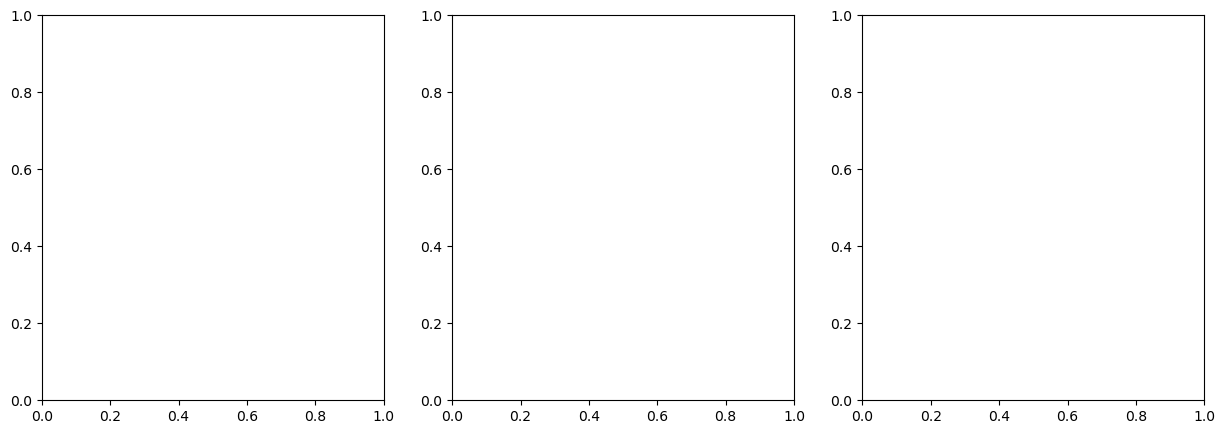

In [107]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
interval = len(data.pcs) // 3 - 1
for i, ax in enumerate(axs):
    scatter = ax.scatter(data.pcs[interval*(i+1)].numpy()[:,0], data.pcs[interval*(i+1)].numpy()[:,1], c=data.data['label'], cmap='tab20')
    ax.set_title(f'Layer {10*(i+1)}')
    handles, _ = scatter.legend_elements()
    labels = ['False', 'True']
    ax.legend(handles, labels)
plt.show()

## 8B Base vs Instruct

In [6]:
base_8b = CodingData('data/factual/hard_100/Meta_Llama_3_1_8B')
instruct_8b = CodingData('data/factual/hard_100/Meta_Llama_3_1_8B_Instruct')

In [8]:
dict_8b = compare_sets(base_8b, instruct_8b)

Base: 0.5959596037864685
Chat: 0.4747474789619446
22 hallucinations improved (22.22%)
10 hallucinations degraded (10.10%)


In [9]:
dict_8b.keys()

dict_keys(['improve_indices', 'degrade_indices', 'both_halluc_indices', 'both_real_indices'])

In [10]:
view_sets(base_8b, instruct_8b, dict_8b['improve_indices'])

The response mentions libraries such as PyDHT, DHTLib, and PyDHTLib, which do not exist as known Python packages for implementing distributed hash tables. Therefore, the response is incorrect. False
The assistant mentions 'Kademlia', which is a real Python package for implementing a DHT. The mention of 'DHT' is less clear, but 'Twisted' is a real networking library that could be used to implement a DHT from scratch. The response is correct because it provides valid options. True



The response mentions `PyAudio`, which is a library for handling audio input and output, but it is not specifically a voice recognition library. For voice recognition, libraries like `SpeechRecognition` or `pocketsphinx` would be more appropriate. Therefore, the response is incorrect in the context of voice recognition. False
The assistant correctly mentions existing Python packages and libraries that can be used for developing a real-time voice recognition system. SpeechRecognition and PyAudio are popular l